<h1 align="center"><font color="yellow">Raspando (Scraping) a Web para aplicativos de PNL</font></h1>

<font color="yellow">Data Scientist.: Dr.Eddy Giusepe Chirinos Isidro</font>

Este script esta baseado no site [The AiEdge NEWSLETTER do Damien Benveniste](https://newsletter.theaiedge.io/)

# Contexto

Hoje em dia, é fácil encontrar dados em qualquer lugar! Vamos vasculhar a web para extrair informações sobre os diferentes ganhadores do `Prêmio Nobel de Física`. Podemos encontrar essa lista na [primeira tabela deste link na Wikipédia](https://en.wikipedia.org/wiki/List_of_Nobel_laureates_in_Physics).

![](https://substackcdn.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2Fa9769d35-7e7a-4d89-895f-f5cf3a814811_500x492.png)

Vamos extrair e usar os dados de texto de cada página da Wikipedia relacionada a esses laureados para construir `métricas de similaridade` e tentar prever qual `Física` eles praticaram.

![](https://substackcdn.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F678e6fcf-94ea-4963-8f04-b600463db0c9_3178x2126.png)

# Preparando o Dataset dos Ganhadores do Prêmio Nobel

## <font color="red">Obtendo os Dados</font>

Vamos obter os dados de todos os laureados com o [Prêmio Nobel de Física da Wikipedia](https://en.wikipedia.org/wiki/List_of_Nobel_laureates_in_Physics). Podemos usar [pd.read_html](https://pandas.pydata.org/docs/reference/api/pandas.read_html.html) para ler diretamente as tabelas da Wikipédia, assim:

In [1]:
import pandas as pd

url = "https://en.wikipedia.org/wiki/List_of_Nobel_laureates_in_Physics"

# Fornecemos a URL ao Pandas:
nobel_tables = pd.read_html(url)

# Pegamos a primeira Tabela --> 0
nobel_df = nobel_tables[0]
nobel_df.head()


,Year,Image,Laureate[A],Country[B],Rationale[C],Ref
0,1901,NaN,Wilhelm Röntgen (1845–1923),German Empire,"""in recognition of the extraordinary services ...",[19]
1,1902,NaN,Hendrik Lorentz (1853–1928),Netherlands,"""in recognition of the extraordinary service t...",[20]
2,1902,NaN,Pieter Zeeman (1865–1943),Netherlands,"""in recognition of the extraordinary service t...",[20]
3,1903,NaN,Antoine Henri Becquerel (1852–1908),France,"""for his discovery of spontaneous radioactivity""",[21]
4,1903,NaN,Pierre Curie (1859–1906),France,"""for their joint researches on the radiation p...",[21]


In [2]:
nobel_df.shape

(228, 6)

## <font color="red">Limpeza de Dados</font>

<font color="orange">Começamos eliminando as colunas que não são relevantes para a nossa análise:</font>

In [3]:
# Eliminamos duas colunas:
nobel_df.drop(['Image', 'Ref'], axis=1, inplace=True)

<font color="orange">Limpamos os nomes das colunas e os traduzimos ao Português:</font>

In [4]:
nobel_df.columns = ['Ano', 'Laureado', 'País', 'Justificativa']

<font color="orange">Eliminamos todas as linhas em que o prêmio Nobel não foi concedido:</font>

In [5]:
nobel_df = nobel_df.loc[~nobel_df['Laureado'].str.startswith('Not awarded')]

# Sempre tem que aplicar o RESET para os Índices, para que eles sejam novamente en forma crescente:
nobel_df.reset_index(drop=True, inplace=True)


In [6]:
nobel_df.head()

,Ano,Laureado,País,Justificativa
0,1901,Wilhelm Röntgen (1845–1923),German Empire,"""in recognition of the extraordinary services ..."
1,1902,Hendrik Lorentz (1853–1928),Netherlands,"""in recognition of the extraordinary service t..."
2,1902,Pieter Zeeman (1865–1943),Netherlands,"""in recognition of the extraordinary service t..."
3,1903,Antoine Henri Becquerel (1852–1908),France,"""for his discovery of spontaneous radioactivity"""
4,1903,Pierre Curie (1859–1906),France,"""for their joint researches on the radiation p..."


In [7]:
nobel_df.shape

(222, 4)

<font color="orange">Verificamos que não temos Dados Missing: </font>

In [8]:
nobel_df.isnull().any()

Ano              False
Laureado         False
País             False
Justificativa    False
dtype: bool

In [9]:
# Também podemos usar
nobel_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222 entries, 0 to 221
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Ano            222 non-null    int64 
 1   Laureado       222 non-null    object
 2   País           222 non-null    object
 3   Justificativa  222 non-null    object
dtypes: int64(1), object(3)
memory usage: 7.1+ KB


# <font color="red">Explorando nossos Dados com algumas perguntas</font>

## <font color="pink">Quantos físicos ganharam um prêmio Nobel?</font>

<font color="orange">Primeiro vou remover as datas da coluna "Laureado", para isso começamos removendo qualquer coisa entre os parênteses usando [RegEx](https://medium.com/xp-inc/regex-um-guia-pratico-para-express%C3%B5es-regulares-1ac5fa4dd39f).</font>

In [10]:
# Assim:
nobel_df['Laureado'] = nobel_df['Laureado'].str.replace('\(.+?\)', '', regex=True)



# ou assim:

# import re

# def Delete_Date(text):
#     text = re.sub(r'\(.+?\)', '', text)
#     return text


# nobel_df['Laureado'] = nobel_df['Laureado'].apply(lambda x: Delete_Date(x))

/tmp/ipykernel_10001/1741914262.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nobel_df['Laureado'] = nobel_df['Laureado'].str.replace('\(.+?\)', '', regex=True)


In [11]:
nobel_df.head()

,Ano,Laureado,País,Justificativa
0,1901,Wilhelm Röntgen,German Empire,"""in recognition of the extraordinary services ..."
1,1902,Hendrik Lorentz,Netherlands,"""in recognition of the extraordinary service t..."
2,1902,Pieter Zeeman,Netherlands,"""in recognition of the extraordinary service t..."
3,1903,Antoine Henri Becquerel,France,"""for his discovery of spontaneous radioactivity"""
4,1903,Pierre Curie,France,"""for their joint researches on the radiation p..."


In [12]:
# Removemos os espaços em branco desnecessários:
nobel_df['Laureado'] = nobel_df['Laureado'].str.strip()



/tmp/ipykernel_10001/3101072319.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nobel_df['Laureado'] = nobel_df['Laureado'].str.strip()


In [13]:
nobel_df.head()

,Ano,Laureado,País,Justificativa
0,1901,Wilhelm Röntgen,German Empire,"""in recognition of the extraordinary services ..."
1,1902,Hendrik Lorentz,Netherlands,"""in recognition of the extraordinary service t..."
2,1902,Pieter Zeeman,Netherlands,"""in recognition of the extraordinary service t..."
3,1903,Antoine Henri Becquerel,France,"""for his discovery of spontaneous radioactivity"""
4,1903,Pierre Curie,France,"""for their joint researches on the radiation p..."


<font color="orange">Obtemos o número único de Físicos:</font>

In [14]:
nobel_df['Laureado'].nunique()

221

<font color="orange">E podemos obter, também, os nomes desses únicos Físicos:</font>

In [15]:
nobel_df['Laureado'].unique()

array(['Wilhelm Röntgen', 'Hendrik Lorentz', 'Pieter Zeeman',
       'Antoine Henri Becquerel', 'Pierre Curie',
       'Marie Skłodowska-Curie', 'Lord Rayleigh',
       'Philipp Eduard Anton von Lenard', 'Joseph John Thomson',
       'Albert Abraham Michelson', 'Gabriel Lippmann',
       'Guglielmo Marconi', 'Karl Ferdinand Braun',
       'Johannes Diderik van der Waals', 'Wilhelm Wien',
       'Nils Gustaf Dalén', 'Heike Kamerlingh-Onnes', 'Max von Laue',
       'William Henry Bragg', 'William Lawrence Bragg',
       'Charles Glover Barkla', 'Max Planck', 'Johannes Stark',
       'Charles Édouard Guillaume', 'Albert Einstein', 'Niels Bohr',
       'Robert Andrews Millikan', 'Manne Siegbahn', 'James Franck',
       'Gustav Hertz', 'Jean Baptiste Perrin', 'Arthur Holly Compton',
       'Charles Thomson Rees Wilson', 'Owen Willans Richardson',
       'Louis Victor Pierre Raymond, 7th Duc de Broglie',
       'Chandrasekhara Venkata Raman', 'Werner Heisenberg',
       'Erwin Schrödinger', 

## <font color="pink">Quantos países estão neste conjunto de Dados?</font>

<font color="orange">Devemos ter cuidado com possíveis Dados duplicados. A seguir, vamos limpar a coluna "País".</font>

In [16]:
nobel_df.head(10)

,Ano,Laureado,País,Justificativa
0,1901,Wilhelm Röntgen,German Empire,"""in recognition of the extraordinary services ..."
1,1902,Hendrik Lorentz,Netherlands,"""in recognition of the extraordinary service t..."
2,1902,Pieter Zeeman,Netherlands,"""in recognition of the extraordinary service t..."
3,1903,Antoine Henri Becquerel,France,"""for his discovery of spontaneous radioactivity"""
4,1903,Pierre Curie,France,"""for their joint researches on the radiation p..."
5,1903,Marie Skłodowska-Curie,Poland France,"""for their joint researches on the radiation p..."
6,1904,Lord Rayleigh,United Kingdom,"""for his investigations of the densities of th..."
7,1905,Philipp Eduard Anton von Lenard,Austria-Hungary German Empire,"""for his work on cathode rays"""
8,1906,Joseph John Thomson,United Kingdom,"""for his theoretical and experimental investig..."
9,1907,Albert Abraham Michelson,German Empire United States,"""for his optical precision instruments and the..."


In [17]:
# Reparamos que ao "printar" da seguinte forma, aparece \xa0:
nobel_df['País'].loc[5]

'Poland \xa0France'

In [21]:
# Removemos qualquer coisa entre colchetes usando RegEx:
nobel_df['País'] = nobel_df['País'].str.replace('\[.+?\]', '', regex=True)

/tmp/ipykernel_10001/286120648.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nobel_df['País'] = nobel_df['País'].str.replace('\[.+?\]', '', regex=True)


<font color="orange">Alguns laureados têm vários países associados a eles. Curiosamente, a `Wikipedia` usa o `caractere ascii` `“\xa0“` (espaço sem quebra em Latin1 (`ISO 8859-1`)) para separar os diferentes países para a mesma pessoa.</font>

In [22]:
nobel_df['País'].apply(ascii)

0      'German Empire'
1        'Netherlands'
2        'Netherlands'
3             'France'
4             'France'
            ...       
217          'Germany'
218            'Italy'
219           'France'
220    'United States'
221          'Austria'
Name: País, Length: 222, dtype: object

In [23]:
nobel_df.head(10)

,Ano,Laureado,País,Justificativa
0,1901,Wilhelm Röntgen,German Empire,"""in recognition of the extraordinary services ..."
1,1902,Hendrik Lorentz,Netherlands,"""in recognition of the extraordinary service t..."
2,1902,Pieter Zeeman,Netherlands,"""in recognition of the extraordinary service t..."
3,1903,Antoine Henri Becquerel,France,"""for his discovery of spontaneous radioactivity"""
4,1903,Pierre Curie,France,"""for their joint researches on the radiation p..."
5,1903,Marie Skłodowska-Curie,Poland France,"""for their joint researches on the radiation p..."
6,1904,Lord Rayleigh,United Kingdom,"""for his investigations of the densities of th..."
7,1905,Philipp Eduard Anton von Lenard,Austria-Hungary German Empire,"""for his work on cathode rays"""
8,1906,Joseph John Thomson,United Kingdom,"""for his theoretical and experimental investig..."
9,1907,Albert Abraham Michelson,German Empire United States,"""for his optical precision instruments and the..."


In [24]:
nobel_df['País'].loc[5]

'Poland \xa0France'

<font color="orange">Assim, podemos dividir cada linha por esse caractere:</font>

In [25]:
nobel_df['País'].str.split('\xa0')

0      [German Empire]
1        [Netherlands]
2        [Netherlands]
3             [France]
4             [France]
            ...       
217          [Germany]
218            [Italy]
219           [France]
220    [United States]
221          [Austria]
Name: País, Length: 222, dtype: object

<font color="orange">E podemos achatar (`Flatten`) tudo em uma lista:</font>

In [33]:
sum(nobel_df['País'].str.split('\xa0').tolist(), [])


['German Empire',
 'Netherlands',
 'Netherlands',
 'France',
 'France',
 'Poland ',
 'France',
 'United Kingdom',
 'Austria-Hungary ',
 'German Empire',
 'United Kingdom',
 'German Empire ',
 'United States',
 'France',
 'Kingdom of Italy',
 'German Empire',
 'Netherlands',
 'German Empire',
 'Sweden',
 'Netherlands',
 'German Empire',
 'United Kingdom',
 'United Kingdom',
 'United Kingdom',
 'German Empire',
 'Weimar Republic',
 'Switzerland',
 'Weimar Republic ',
 'Switzerland',
 'Denmark',
 'United States',
 'Sweden',
 'Weimar Republic',
 'Weimar Republic',
 'France',
 'United States',
 'United Kingdom',
 'United Kingdom',
 'France',
 'India',
 'Weimar Republic',
 'Austria',
 'United Kingdom',
 'United Kingdom',
 'Austria',
 'United States',
 'United States',
 'United Kingdom',
 'Kingdom of Italy',
 'United States',
 'United States',
 'United States',
 'Austria',
 'United States',
 'United Kingdom',
 'United Kingdom',
 'Japan',
 'United Kingdom',
 'United Kingdom',
 'Ireland',
 'Swi

E agora, podemos simplesmente contar o número de países:

In [26]:
pd.Series(sum(nobel_df['País'].str.split('\xa0').tolist(), [])).str.strip().nunique()


30

<font color="orange">Vejamos a distribuição dos países:</font>

* Imprimimos os países com o número de vezes que está contido na `série de pandas dos países`. Podemos usar a função [pd.Series.value_counts](https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html).

* Traçamos um `barplot` ordenado por esses números. Podemos usar a função [pd.plot](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html) alterando o tipo do argumento.

In [29]:
# Criamos uma variável countries:
countries = pd.Series(sum(nobel_df['País'].str.split('\xa0').tolist(), [])).str.strip()

# seguidamente contamos:
countries.value_counts()


United States        99
United Kingdom       28
France               15
Japan                12
West Germany         11
Netherlands          10
German Empire         8
Germany               8
Switzerland           7
Soviet Union          7
Canada                6
Russia                5
Weimar Republic       5
Sweden                4
Italy                 4
Austria               4
Republic of China     4
Denmark               3
Hungary               2
Poland                2
Kingdom of Italy      2
India                 2
Belgium               1
Australia             1
Hong Kong             1
Ireland               1
Pakistan              1
Norway                1
Austria-Hungary       1
Slovenia              1
dtype: int64

<font color="orange">E Plotamos:</font>

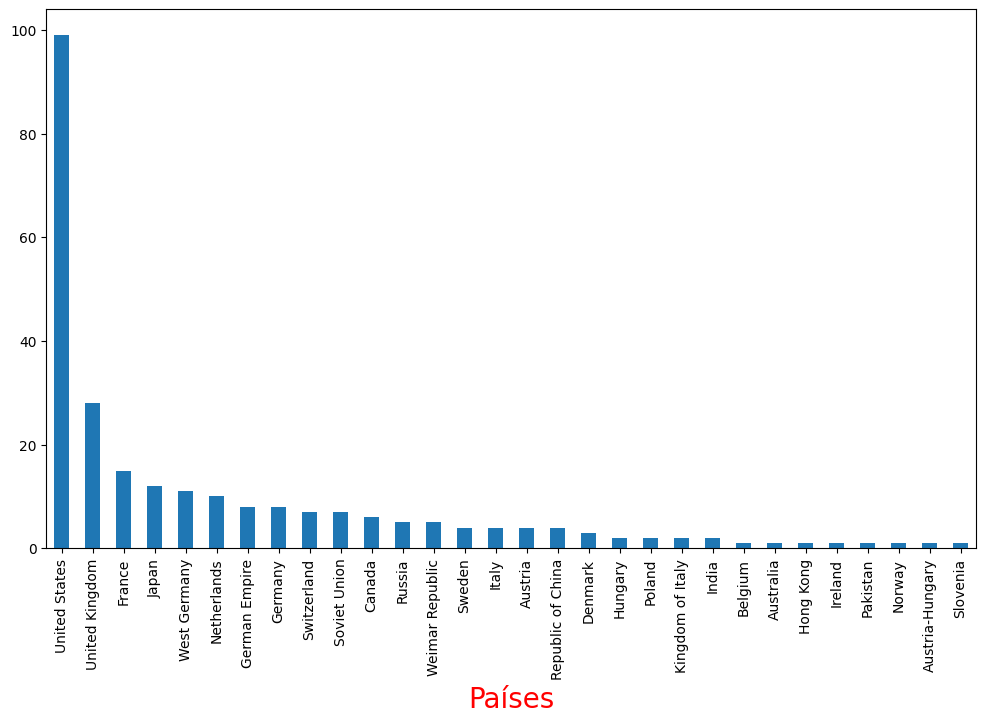

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline


fig = plt.figure(figsize=(12, 7))
countries.value_counts().plot.bar()
plt.xlabel("Países", c='r', size=20)
plt.show()
